# Uyku Durumlarını Tespit Etme

*Bu yarışma, bilekten takılan ivmeölçer verilerini kullanarak uyku başlangıcını ve uyanıklığı tespit etmeyi amaçlamaktadır. Yarışmanın temel hedefi, kişinin uyku durumunu belirleyebilecek bir model geliştirmektir. Bu model, araştırmacıların daha güvenilir ve daha geniş çaplı uyku çalışmaları yapmalarını sağlayabilir. Bu tür çalışmalar, uyku hakkında daha fazla bilgi sağlayabilir.
*
*Yarışmanın başarılı bir sonucu, özellikle ruh hali ve davranış zorlukları yaşayan çocuklar ve gençler için önemli sonuçlar doğurabilir. Uyku, bireylerin ruh hali, duyguları ve davranışlarını düzenlemede çok önemlidir, özellikle de çocuklar için. Bilekten takılan ivmeölçer verilerinden uyku ve uyanıklık dönemlerini doğru bir şekilde tespit ederek, araştırmacılar uyku modellerini daha iyi anlayabilir ve çocuklarda uyku bozukluklarını daha iyi anlayabilirler.*

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import pairplot
plt.style.use('ggplot') 
import seaborn as sb
import plotly.express as px
from matplotlib import rcParams
from scipy.fft import fft

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_row', 100)

import warnings
warnings.filterwarnings("ignore")

# Loading the Data and EDA 

In [134]:
data = pd.read_csv('/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv')
data.head()

test_data = pd.read_csv('/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv')

sample = pd.read_csv('/kaggle/input/child-mind-institute-detect-sleep-states/sample_submission.csv')

In [135]:
print("<**********************************Decsribe**********************************>")
print("")
print(data.describe())
print("")
print("<**********************************Info**********************************>")
print("")
print(data.info())
print("")
print("<**********************************Columns**********************************>")
print("")
print(data.columns)
print("")
print("<**********************************Null**********************************>")
print("")
print(data.isnull().sum())
print("")
print('Number of null values:', data.isnull().sum().sum())

<**********************************Decsribe**********************************>

              night           step
count  14508.000000    9585.000000
mean      15.120072  214352.123944
std       10.286758  141268.408192
min        1.000000     936.000000
25%        7.000000   95436.000000
50%       14.000000  200604.000000
75%       21.000000  317520.000000
max       84.000000  739392.000000

<**********************************Info**********************************>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14508 entries, 0 to 14507
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   series_id  14508 non-null  object 
 1   night      14508 non-null  int64  
 2   event      14508 non-null  object 
 3   step       9585 non-null   float64
 4   timestamp  9585 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 566.8+ KB
None

<**********************************Columns****************************

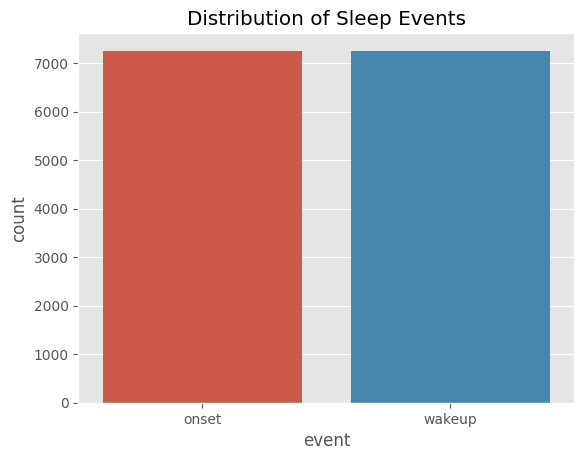

In [136]:
sns.countplot(x='event', data=data)
plt.title('Distribution of Sleep Events')
plt.show()

# Data preprocessing

In [137]:
data['step'].fillna(data['step'].mean(), inplace=True)

# Converting datetime format
data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y-%m-%dT%H:%M:%S%z')

# Group by 'series_id' and fill null values in 'timestamp' using the forward fill method within each group
data['timestamp'] = data.groupby('series_id')['timestamp'].ffill()

In [138]:
data.isnull().sum()

series_id      0
night          0
event          0
step           0
timestamp    480
dtype: int64

In [139]:
data.dropna(inplace=True)

In [140]:
data.isnull().sum()

series_id    0
night        0
event        0
step         0
timestamp    0
dtype: int64

# Feature Engineering

In [141]:
data

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.000000,2018-08-14 22:26:00-04:00
1,038441c925bb,1,wakeup,10932.000000,2018-08-15 06:41:00-04:00
2,038441c925bb,2,onset,20244.000000,2018-08-15 19:37:00-04:00
3,038441c925bb,2,wakeup,27492.000000,2018-08-16 05:41:00-04:00
4,038441c925bb,3,onset,39996.000000,2018-08-16 23:03:00-04:00
...,...,...,...,...,...
14503,fe90110788d2,33,wakeup,560604.000000,2017-09-06 04:07:00-04:00
14504,fe90110788d2,34,onset,574620.000000,2017-09-06 23:35:00-04:00
14505,fe90110788d2,34,wakeup,581604.000000,2017-09-07 09:17:00-04:00
14506,fe90110788d2,35,onset,214352.123944,2017-09-07 09:17:00-04:00


In [142]:
data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y-%m-%dT%H:%M:%S%z', utc=True)
data['hour'] = data['timestamp'].dt.hour

label_encoder = LabelEncoder()
data['event'] = label_encoder.fit_transform(data['event'])

series_stats = data.groupby('series_id')['step'].agg(['mean', 'std', 'max', 'min']).reset_index()
data = pd.merge(data, series_stats, on='series_id', suffixes=('', '_series_stats'))

data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)

In [143]:
data

,series_id,night,event,step,timestamp,hour,mean,std,max,min,hour_sin,hour_cos
0,038441c925bb,1,0,4992.000000,2018-08-15 02:26:00+00:00,2,198564.108512,104923.552035,369912.0,4992.0,0.500000,0.866025
1,038441c925bb,1,1,10932.000000,2018-08-15 10:41:00+00:00,10,198564.108512,104923.552035,369912.0,4992.0,0.500000,-0.866025
2,038441c925bb,2,0,20244.000000,2018-08-15 23:37:00+00:00,23,198564.108512,104923.552035,369912.0,4992.0,-0.258819,0.965926
3,038441c925bb,2,1,27492.000000,2018-08-16 09:41:00+00:00,9,198564.108512,104923.552035,369912.0,4992.0,0.707107,-0.707107
4,038441c925bb,3,0,39996.000000,2018-08-17 03:03:00+00:00,3,198564.108512,104923.552035,369912.0,4992.0,0.707107,0.707107
...,...,...,...,...,...,...,...,...,...,...,...,...
14023,fe90110788d2,33,1,560604.000000,2017-09-06 08:07:00+00:00,8,298233.944822,164201.202936,581604.0,21048.0,0.866025,-0.500000
14024,fe90110788d2,34,0,574620.000000,2017-09-07 03:35:00+00:00,3,298233.944822,164201.202936,581604.0,21048.0,0.707107,0.707107
14025,fe90110788d2,34,1,581604.000000,2017-09-07 13:17:00+00:00,13,298233.944822,164201.202936,581604.0,21048.0,-0.258819,-0.965926
14026,fe90110788d2,35,0,214352.123944,2017-09-07 13:17:00+00:00,13,298233.944822,164201.202936,581604.0,21048.0,-0.258819,-0.965926


In [144]:
x = data[['step', 'hour', 'hour_sin', 'night']]
y = data['event']

In [145]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# LogisticRegression 

In [146]:
log = LogisticRegression(random_state=42)

In [147]:
log.fit(x_train, y_train)
pred = log.predict(x_test)

# Model Evaluation
accuracy_test = accuracy_score(y_test, pred)
classification_rep_test = classification_report(y_test, pred)

print("Model: ",log)
print("")
print(f'Test Accuracy: {accuracy_test}')
print("")
print(f'Classification Report (Test Set):\n{classification_rep_test}')

Model:  LogisticRegression(random_state=42)

Test Accuracy: 0.5131860299358517

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1366
           1       0.51      1.00      0.68      1440

    accuracy                           0.51      2806
   macro avg       0.26      0.50      0.34      2806
weighted avg       0.26      0.51      0.35      2806



# GaussianNB 

In [167]:
gnb = GaussianNB()

In [173]:
gnb.fit(x_train, y_train)
pred = gnb.predict(x_test)

# Model Evaluation
accuracy_score_of_all = accuracy_score(y_test, pred)
average_precision = classification_report(y_test, pred)

print("Model: ",gnb)
print("")
print("Validation Accuracy: ", accuracy_score_of_all)
print("")
print("Average Precision: ", average_precision)

Model:  GaussianNB()

Validation Accuracy:  0.8292943692088383

Average Precision:                precision    recall  f1-score   support

           0       0.96      0.68      0.79      1366
           1       0.76      0.97      0.85      1440

    accuracy                           0.83      2806
   macro avg       0.86      0.83      0.82      2806
weighted avg       0.86      0.83      0.83      2806



In [170]:
param_grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
grid_search = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(x_train, y_train)  # Uzun sürebilir, daha küçük bir parametre setiyle deneyin

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ....................var_smoothing=0.657933224657568; total time=   0.0s
[CV] END ....................var_smoothing=0.533669923120631; total time=   0.0s
[CV] END ..................var_smoothing=0.43287612810830584; total time=   0.0s
[CV] END ...................var_smoothing=0.3511191734215131; total time=   0.0s
[CV] END ...................var_smoothing=0.2848035868435802; total time=   0.0s
[CV] END ..................var_smoothing=0.23101297000831597; total time=   0.0s
[CV] END ...................var_smoothing=0.1873817422860384; total time=   0.0s
[CV] END ..................................var_smoothing=0.1; total time=   0.0s
[CV] END ..................................var_smoothing=0.1; total time=   0.0s
[CV] END ...................var_smoothing=0.0533669923120631; total time=   0.0s
[CV] END ...................var_smoothing=0.05

GridSearchCV(cv=3, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.8480358...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='accuracy', verbose=2)

In [172]:
best_params = grid_search.best_params_
gnb_classifier_best = GaussianNB(**best_params)

gnb_classifier_best.fit(x_train, y_train)

y_pred_best = gnb_classifier_best.predict(x_test)
accuracy_best = accuracy_score(y_test, y_pred_best)

print("En iyi parametrelerle elde edilen doğruluk:", accuracy_best)

En iyi parametrelerle elde edilen doğruluk: 0.8285816108339273


# DecisionTreeClassifier

In [153]:
dt = DecisionTreeClassifier(random_state=42)

In [154]:
dt.fit(x_train, y_train)
pred = dt.predict(x_test)

# Model Evaluation
accuracy_test = accuracy_score(y_test, pred)
average_precision = classification_report(y_test, pred)

print("Model: ",dt)
print("")
print("Validation Accuracy: ", accuracy_test)
print("")
print("Average Precision: ", average_precision)

Model:  DecisionTreeClassifier(random_state=42)

Validation Accuracy:  0.7594440484675695

Average Precision:                precision    recall  f1-score   support

           0       0.72      0.82      0.77      1366
           1       0.80      0.70      0.75      1440

    accuracy                           0.76      2806
   macro avg       0.76      0.76      0.76      2806
weighted avg       0.76      0.76      0.76      2806



# RandomForestClassifier

In [155]:
rf= RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=300)   

In [156]:
rf.fit(x_train,y_train)
pred=rf.predict(x_test)

accuracy_test = accuracy_score(y_test, pred)
average_precision = classification_report(y_test, pred)

print("Model: ",rf)
print("")
print("Validation Accuracy: ", accuracy_test)
print("")
print("Average Precision: ", average_precision)

Model:  RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=300)

Validation Accuracy:  0.7665716322166786

Average Precision:                precision    recall  f1-score   support

           0       0.74      0.79      0.77      1366
           1       0.79      0.74      0.77      1440

    accuracy                           0.77      2806
   macro avg       0.77      0.77      0.77      2806
weighted avg       0.77      0.77      0.77      2806



# En İyi Sonuç Veren Model

In [175]:
print("Model: ",gnb)
print("")
print("Accuracy: ", accuracy_score_of_all)

Model:  GaussianNB()

Accuracy:  0.8292943692088383
